In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [19]:
directory='.'
# directory='/content/drive/MyDrive/esn2sparse'; 
# !cp "/content/drive/MyDrive/esn2sparse/params.py" "."

In [20]:
import torch
import numpy as np
import sympy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as pl
import torchvision
import torchvision.datasets as datasets
import time
import torch.jit as jit
from torch import nn
from torch import optim
from os.path import exists
import gc
import importlib
import params_feedback as par
import time
import os
device = 'cpu'
# device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [21]:
mnist_trainset = datasets.MNIST(root=directory+'/data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root=directory+'/data', train=False, download=True, transform=None)

In [23]:
X_te=mnist_testset.data               ## Test set images
y_te=mnist_testset.test_labels        ## Test set labels

N_o=10                                ## Number of output nodes/classes
N_te=y_te.size()[0]                   ## Number of test samples
Y_te=torch.zeros([N_te,N_o])          ## Initialisation of the one-hot encoded labels for the test set
Y_te[np.arange(0,N_te),y_te]=1        ## From labels to one-hot encoded labels for the test set

X_tr=mnist_trainset.data              ## Train set images
y_tr=mnist_trainset.train_labels      ## Train labels 
N_tr=y_tr.size()[0]                   ## Number of training samples
N_i = X_tr.size()[1]                  ## Number of inputs to ESN

Y_tr=torch.zeros([N_tr,N_o])          ## Initialisation of one-hot encoded labels for training
Y_tr[np.arange(0,N_tr),y_tr]=1        ## From labels to one-hot encoded labels for the training set

N_val=10000                           ## Here I take out N_val samples from the training set and use them for validation
i_val=np.random.permutation(np.arange(0,N_tr))[0:N_val]

X_val=X_tr[i_val,:,:]
Y_val=Y_tr[i_val,:]

i_tr=np.delete(np.arange(0,N_tr),i_val)
N_tr=N_tr-N_val

X_tr=X_tr[i_tr,:,:]
Y_tr=Y_tr[i_tr,:]

T=X_tr.size()[2]
N_in=X_tr.size()[1]

## Normalisation and conversion to float
X_M=255
# X_tr=torch.reshape( (X_tr.float()/X_M),[-1,784]) 
# X_val=torch.reshape((X_val.float()/X_M),[-1,784])
# X_te=torch.reshape((X_te.float()/X_M),[-1,784])
X_tr=torch.reshape( (X_tr.float()),[-1,784]).to(device)
X_val=torch.reshape((X_val.float()),[-1,784]).to(device)
X_te=torch.reshape((X_te.float()),[-1,784]).to(device)

for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

X_tr=torch.reshape( (X_tr),[-1,28,28]) 
X_val=torch.reshape((X_val),[-1,28,28])
X_te=torch.reshape((X_te),[-1,28,28])

Y_tr=Y_tr.float().to(device)
Y_val=Y_val.float().to(device)
Y_te=Y_te.float().to(device)

print(f'X_tr shape = {X_tr.shape},    Y_tr shape = {Y_tr.shape}')


X_tr shape = torch.Size([50000, 28, 28]),    Y_tr shape = torch.Size([50000, 10])


In [ ]:
# Add random contrast transformations to input data (OLD VERSION - results in outlines)
for j in range(X_tr.shape[0]):
    X_tr[j,X_tr[j,:]==X_tr[j,:].min()] = X_tr[j,X_tr[j,:]==X_tr[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_tr[j,:].max() - X_tr[j,:].min())
for j in range(X_val.shape[0]):
    X_val[j,X_val[j,:]==X_val[j,:].min()] = X_val[j,X_val[j,:]==X_val[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_val[j,:].max() - X_val[j,:].min())
for j in range(X_te.shape[0]):
    X_te[j,X_te[j,:]==X_te[j,:].min()] = X_te[j,X_te[j,:]==X_te[j,:].min()] + torch.rand(1).to(device) * torch.tensor(2.).to(device) * (X_te[j,:].max() - X_te[j,:].min())

# Z-score inputs
for j in range(X_tr.shape[0]):
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= torch.std(X_tr[j,:])

for j in range(X_val.shape[0]):
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= torch.std(X_val[j,:])

for j in range(X_te.shape[0]):
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= torch.std(X_te[j,:])

In [124]:
# Add random contrast transformations to input data
contrast_mean = torch.tensor(0.5).to(device)
contrast_range = torch.tensor(0.99).to(device)
# Training data
for j in range(X_tr.shape[0]):
    # Rescale values to range 0-1
    X_tr[j,:] -= torch.min(X_tr[j,:])
    X_tr[j,:] /= torch.max(X_tr[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_tr[j,:] = torch.tensor(1.0).to(device) - X_tr[j,:]
    # Z-score
    X_tr[j,:] -= torch.mean(X_tr[j,:])
    X_tr[j,:] /= (torch.std(X_tr[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

# Validation data
for j in range(X_val.shape[0]):
    # Rescale values to range 0-1
    X_val[j,:] -= torch.min(X_val[j,:])
    X_val[j,:] /= torch.max(X_val[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_val[j,:] = torch.tensor(1.0).to(device) - X_val[j,:]
    # Z-score
    X_val[j,:] -= torch.mean(X_val[j,:])
    X_val[j,:] /= (torch.std(X_val[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

# Test data
for j in range(X_te.shape[0]):
    # Rescale values to range 0-1
    X_te[j,:] -= torch.min(X_te[j,:])
    X_te[j,:] /= torch.max(X_te[j,:])
    # Reverse contrast with prob. = 0.5
    if torch.rand(1)>0.5:
        X_te[j,:] = torch.tensor(1.0).to(device) - X_te[j,:]
    # Z-score
    X_te[j,:] -= torch.mean(X_te[j,:])
    X_te[j,:] /= (torch.std(X_te[j,:]) / (contrast_mean + contrast_range*(torch.rand(1).to(device) - torch.tensor(0.5).to(device))))

In [ ]:
# IF NOT USING ESN
# Make inputs 2800-dim and z-score
from scipy import stats
with torch.no_grad():
    w = torch.randn([784, par.N_esn*28]).to(device)/torch.sqrt(torch.tensor(par.N_esn*28+784)).to(device)
    batchsize = torch.tensor(100).to(device)
    # Operate on batches of data to save GPU-memory
    # Training data
    nbatch = torch.ceil(X_tr.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_tr.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_tr[j*batchsize:min((j+1)*batchsize,X_tr.shape[0]),:,:].reshape(batchsize, X_tr.shape[1]*X_tr.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_tr.shape[0]), :] = torch.clone(temp).to(device)
    X_tr = torch.clone(perm).cpu()
    # Validation data
    nbatch = torch.ceil(X_val.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_val.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_val[j*batchsize:min((j+1)*batchsize,X_val.shape[0]),:,:].reshape(batchsize, X_val.shape[1]*X_val.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_val.shape[0]), :] = torch.clone(temp).to(device)
    X_val = torch.clone(perm).cpu()
    # Test data
    nbatch = torch.ceil(X_te.shape[0]/batchsize).int()
    temp = torch.zeros(batchsize, par.N_esn*28).to(device)
    perm = torch.zeros(X_te.shape[0], par.N_esn*28).cpu()
    for j in range(nbatch):    
        temp = torch.matmul(X_te[j*batchsize:min((j+1)*batchsize,X_te.shape[0]),:,:].reshape(batchsize, X_te.shape[1]*X_te.shape[2]), w)
        temp -= torch.matmul(temp.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
        temp /= temp.std()
        perm[j*batchsize:min((j+1)*batchsize,X_te.shape[0]), :] = torch.clone(temp).to(device)
    X_te = torch.clone(perm).cpu()
    
    # X_tr -= torch.matmul(X_tr.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
    # X_tr /= X_tr.mean()
    # X_tr -= torch.matmul(X_tr.mean(dim=1, keepdim=True), torch.ones(1, par.N_esn * 28).to(device))
    # X_tr /= X_tr.mean()

    # X_tr = torch.tensor(stats.zscore(torch.matmul(X_tr.reshape(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]), w).numpy(), axis=1))
    # X_val = torch.tensor(stats.zscore(torch.matmul(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), w).numpy(), axis=1))
    # X_te = torch.tensor(stats.zscore(torch.matmul(X_te.reshape(X_te.shape[0], X_te.shape[1]*X_te.shape[2]), w).numpy(), axis=1))



In [24]:
def Data2Classes(X,Y):
    
    ind=torch.where(Y==1)[1]

    N_class=torch.max(ind)+1
    
    X1=[]
    Y1=[]
    
    for n in range(N_class):
    
        ind1=torch.where(ind==n)[0].type(torch.long)

        X1.append(X[ind1,:].to(device))
        Y1.append(Y[ind1,:].to(device))
        
    return X1, Y1
        
# X_tr/X_val/X_te are lists of length 10 (1 entry per class)
X_tr, Y_tr=Data2Classes(X_tr,Y_tr)

X_val, Y_val=Data2Classes(X_val,Y_val)

X_te, Y_te=Data2Classes(X_te,Y_te)

In [ ]:
# Plot activity and correlation between classes
N_esn = par.N_esn
a = np.zeros((1000,N_esn*28))
for j in range(len(X_tr)):
    a[j*100:(j+1)*100,:] = X_tr[j][0:100,:].numpy()
print(np.max(a), np.min(a))
c = np.matmul(stats.zscore(a,axis=1), np.transpose(stats.zscore(a,axis=1))) / a.shape[1]
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[0][0:1000,:],vmin=-2.0, vmax=2.0)
fig = pl.figure(figsize=tuple(np.array((50.,20.))/2.54)); ax = pl.axes()
imdata = ax.imshow(X_tr[2][0:1000,:],vmin=-2.0, vmax=2.0)
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
imdata = ax.imshow(c,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[0, 1.0])

In [6]:
class NN(nn.Module):
    
    def __init__(self,Ns,N_class):
        super().__init__()
        
        self.N_class=N_class
        N_layers=np.shape(Ns)[0]
        
        self.Ws=[]
        self.bs=[]
        
        self.Ths=[]
        self.Th_bs=[]
        
        self.Ns=Ns
        for n in range(1,np.shape(Ns)[0]):
        
            self.Ws.append(nn.Parameter(torch.randn([Ns[n-1],Ns[n]]).to(device)/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n]))))
            self.bs.append(nn.Parameter(torch.zeros([Ns[n]]).to(device)))

        
        self.Ths.append( nn.Parameter( torch.randn([Ns[-1],N_class])/torch.sqrt(torch.tensor(Ns[n-1]+Ns[n])) ) ) 
        self.Th_bs.append( nn.Parameter(torch.zeros([N_class])) )
        
    def Initialise_Hyperparameters(self,eta_t, eta_o,batch_size,margin):


        self.eta_t=eta_t
        self.eta_o=eta_o
        self.batch_size=batch_size

        self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta_t }])
        
        self.opt_out=optim.Adam([{ 'params': self.Ths+self.Th_bs, 'lr':eta_o }])
                              
        self.margin=margin
        
        
    def Forward_Triplet(self, S):
        
        ys=[]
        ns = S.shape[1] # Number of samples
        ACC = 0.0
        o = torch.ones(9,1)
        for k in range(3):
        
            xs=[]
            xs.append(S[k,:,:])

            for n in range(0,np.shape(self.Ns)[0]-2):
                # Compute activities in each layer
                xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

            ys.append( torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1]) )
        
        # # Use Euclidean distance
        # dneg = torch.sum( torch.pow( ys[0].detach()-ys[2].detach(), 2 ), 1)
        # dposneg = torch.sum( torch.pow( ys[1].detach()-ys[2].detach(), 2 ), 1)
        # # Find the hard negative pairs and swap anchor and positive if dposneg>dneg
        # ind = dneg > dposneg
        # acopy = torch.clone(ys[0])
        # ys[0][ind,:] = torch.clone(ys[1][ind,:])
        # ys[1][ind,:] = torch.clone(acopy[ind,:])
        # Recompute distances
        dpos = torch.sum( torch.pow( ys[0]-ys[1], 2 ), 1)
        dneg = torch.sum( torch.pow( ys[0]-ys[2], 2 ), 1)
        
        E = dpos - dneg + self.margin
        E = torch.mean( E*(E>0) )
        if E>0:
            
            E.backward()
        
            self.opt.step()
            self.opt.zero_grad()
        
        # # Use correlation
        # a = (ys[0] - torch.matmul(torch.mean(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[0],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # p = (ys[1] - torch.matmul(torch.mean(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[1],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # n = (ys[2] - torch.matmul(torch.mean(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))) / torch.matmul(torch.std(ys[2],1,keepdim=True), torch.ones(1,ys[0].shape[1]))
        # dpos = torch.sum( torch.mul(a,p) ,1) / a.shape[1]
        # dneg = torch.sum( torch.mul(a,n) ,1) / a.shape[1]
        # E = torch.mean(dneg - dpos)
        
        # E.backward()
    
        # self.opt.step()
        # self.opt.zero_grad()

        # print(f'-----  Triplet loss = {torch.mean(E)},-----  +ve = {torch.mean(dpos)},------  -ve = {torch.mean(dneg)}')
        
        dn = torch.zeros(ns)
        for j in range(ns):            
            ind1 = torch.randperm(ns)
            dn = torch.sum(torch.pow(torch.matmul(o, ys[0][j,None,:]) - ys[2][ind1[0:9],:], 2.), 1)
            ACC += torch.any(dpos[j]*o > dn).logical_not().long()
        ACC /= ns

        return E, ACC, torch.mean(dpos), torch.mean(dneg)
        
        
    def Forward_out(self, S, Y):
       
        
        xs=[]
        xs.append(S)

        for n in range(0,np.shape(self.Ns)[0]-2): # For each layer except the final layer
            # Build up training data so that outputs learn from all previous layers
            xs.append(torch.relu( torch.add(torch.matmul(xs[n],self.Ws[n]),self.bs[n]) ) )

        y= torch.add(torch.matmul(xs[-1],self.Ws[-1]),self.bs[-1])
        out=torch.add(torch.matmul(y.detach(),self.Ths[0]),self.Th_bs[0]) 
        
        E_out=torch.mean(torch.sum( torch.pow( out-Y, 2 ), 1))
        
        Acc=torch.mean(torch.eq( torch.argmax(out,1), torch.argmax(Y,1) ).type(torch.float))
        
        E_out.backward()
        
        self.opt_out.step()
        self.opt_out.zero_grad()
        
        
        return E_out, Acc
        
        
    

In [116]:
class MLPclassic(nn.Module):
    
    def __init__(self,par):
        super().__init__()

        self.N_class=par.nClass

        self.N = par.N_esn
        self.alpha = par.alpha
        self.rho = par.rho
        self.N_av = par.N_av
        self.N_i = par.nInputs
        self.gamma = par.gamma

        dilution = 1-self.N_av/self.N
        W = np.random.uniform(-1, 1, [self.N, self.N])
        W = W*(np.random.uniform(0, 1, [self.N, self.N]) > dilution)
        eig = np.linalg.eigvals(W)
        self.W = torch.from_numpy(
            self.rho*W/(np.max(np.absolute(eig)))).float()

        self.x = []

        if self.N_i == 1:

            self.W_in = 2*np.random.randint(0, 2, [self.N_i, self.N])-1
            self.W_in = torch.from_numpy(self.W_in*self.gamma).float()

        else:

            self.W_in = np.random.randn(self.N_i, self.N)
            self.W_in = torch.from_numpy(self.gamma*self.W_in).float()

        self.Ws=[]
        self.bs=[]
        
        self.Ns=par.Ns
        for n in range(1,np.shape(self.Ns)[0]):
        
            self.Ws.append(nn.Parameter(torch.randn([self.Ns[n-1],self.Ns[n]]).to(device)/torch.sqrt(torch.tensor(self.Ns[n-1]+self.Ns[n]))))
            self.bs.append(nn.Parameter(torch.zeros([self.Ns[n]]).to(device)))
        
        if par.fbLayer:
            self.fbLayer = par.fbLayer
            self.W_fb = nn.Parameter(torch.randn([self.Ns[self.fbLayer],self.N])/10**4).to(device)

    def Initialise_Hyperparameters(self,eta,batch_size):

        self.eta=eta
        self.batch_size=batch_size
        if hasattr(self,'fbLayer'):
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs+[self.W_fb], 'lr':eta }])
        else:
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta }])
        
    def Forward(self):

        for n in range(0,len(self.Ns)-1): # For each layer
            # Build up training data so that outputs learn from all previous layers
            self.x[n+1] = torch.clone(torch.relu( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))

    def Reset(self, nSamples):

        self.x = []
        for n in range(0,len(self.Ns)): # For each layer
            self.x.append(torch.zeros(nSamples, self.Ns[n], requires_grad=True))

    def ESN_1step(self, s, t):
        if t>0:
            if hasattr(self,'fbLayer'):
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)+torch.matmul(self.x[self.fbLayer], self.W_fb)))
            else:
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)))
        else:
            self.x[0] = torch.clone(self.alpha * torch.tanh(torch.matmul(s, self.W_in)))

    def response(self, Input, Y, backwardFlag=True):


        self.opt.zero_grad()
        N_samples = Input.shape[0]
        T = Input.shape[2]
        E = 0.

        self.Reset(N_samples,T)
        # YY = torch.tile(Y.unsqueeze(2),[1,1,T])
        for t in range(T):

            self.ESN_1step(Input[:, :, t], t)
            self.Forward()
            # E += torch.mean(torch.sum( torch.pow( self.x[-1]-Y, 2 ), 1))
    
        Acc=torch.mean(torch.eq( torch.argmax(self.x[-1],1), torch.argmax(Y,1) ).type(torch.float))
        # Compute Loss
        p = torch.div( torch.exp(self.x[-1]), torch.sum(torch.exp(self.x[-1]), 1, keepdim=True).tile((1,self.x[-1].shape[1])) )
        ind = range(N_samples)
        E = torch.mean(- torch.log(p[ind,torch.argmax(Y,1)]))
        # E = torch.mean(torch.sum( torch.pow( self.x[-1]-Y, 2 ), 1))
        # E /= T
        if backwardFlag:
            E.backward()
            self.opt.step()

        return E,Acc
    
    def responseSave(self, Input,saveLayers=[]):

        N_samples = Input.shape[0]
        T = Input.shape[2]
        
        sav = []
        for l in saveLayers:
            sav.append(torch.zeros(N_samples, self.Ns[l], T))

        self.Reset(N_samples,T)
        for t in range(T):

            self.ESN_1step(Input[:, :, t], t)
            self.Forward(t)
            
            for li, l in enumerate(saveLayers):
                sav[li][:,:,t] = torch.clone(self.x[l].detach())
    
        return sav

In [1]:
class MLPmetric(nn.Module):
    
    def __init__(self,par):
        super().__init__()

        self.N_class=par.nClass

        self.N = par.N_esn
        self.alpha = par.alpha
        self.rho = par.rho
        self.N_av = par.N_av
        self.N_i = par.nInputs
        self.gamma = par.gamma
        self.tMax = par.tMax
        self.batch_size = par.batch_size
        self.nSampPerClassPerBatch = int(par.batch_size/par.nClass) # No. input samples per class, per batch
        self.maxLayer = par.maxLayer
        self.lossLayer = par.lossLayer
        self.metricLossType = par.metricLossType
        self.margin = par.margin
        self.tri = 1 if par.metricLossType=='tripletLoss' else 0
        self.wPerf = torch.exp(-torch.arange(self.tMax).flip(0)/par.tauPerf)

        dilution = 1-self.N_av/self.N
        W = np.random.uniform(-1, 1, [self.N, self.N])
        W = W*(np.random.uniform(0, 1, [self.N, self.N]) > dilution)
        eig = np.linalg.eigvals(W)
        self.W = torch.from_numpy(
            self.rho*W/(np.max(np.absolute(eig)))).float()

        self.x = []

        if self.N_i == 1:

            self.W_in = 2*np.random.randint(0, 2, [self.N_i, self.N])-1
            self.W_in = torch.from_numpy(self.W_in*self.gamma).float()

        else:

            self.W_in = np.random.randn(self.N_i, self.N)
            self.W_in = torch.from_numpy(self.gamma*self.W_in).float()

        self.Ws=[]
        self.bs=[]
        
        self.Ns=par.Ns
        self.numW = 0 # Total number of feedforward weights
        for n in range(1,np.shape(self.Ns)[0]):
        
            self.Ws.append(nn.Parameter((torch.randn([self.Ns[n-1],self.Ns[n]])/torch.sqrt(torch.tensor(self.Ns[n-1]+self.Ns[n])).to(device))))
            self.bs.append(nn.Parameter(torch.zeros([self.Ns[n]]).to(device)))

            self.numW += float(torch.numel(self.Ws[n-1]))
        
        if par.fbLayer:
            self.fbLayer = par.fbLayer
            self.W_fb = nn.Parameter(torch.randn([self.Ns[self.fbLayer],self.N])/10**4).to(device)

    def Initialise_Hyperparameters(self,eta,batch_size):

        self.eta=eta
        self.batch_size=batch_size
        if hasattr(self,'fbLayer'):
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs+[self.W_fb], 'lr':eta }])
        else:
            self.opt=optim.Adam([{ 'params': self.Ws+self.bs, 'lr':eta }])
        
    def Forward(self):

        for n in range(0,np.minimum(self.maxLayer+1,len(self.Ns))-1): # For each layer, up to maxLayer
            # Build up training data so that outputs learn from all previous layers
            # self.x[n+1] = torch.clone(torch.log(torch.tensor(1.) + torch.relu(torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n])) ))
            self.x[n+1] = torch.clone(torch.relu( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))
            # if n==(self.maxLayer-1):
            #     # Use Sigmoid for output layer
            #     self.x[n+1] = torch.clone(torch.sigmoid( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))
            # else:
            #     # Use ReLU
            #     self.x[n+1] = torch.clone(torch.relu( torch.add(torch.matmul(self.x[n],self.Ws[n]),self.bs[n]) ))

    def Reset(self, nSamples):

        self.x = []
        for n in range(0,len(self.Ns)): # For each layer
            self.x.append(torch.zeros(nSamples, self.Ns[n], requires_grad=False))

    def ESN_1step(self, s, t):
        if t>0:
            if hasattr(self,'fbLayer'):
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)+torch.matmul(self.x[self.fbLayer], self.W_fb)))
            else:
                self.x[0] = torch.clone((1-self.alpha)*self.x[0]+self.alpha * \
                    torch.tanh(torch.matmul(s, self.W_in)+torch.matmul(self.x[0], self.W)))
        else:
            self.x[0] = torch.clone(self.alpha * torch.tanh(torch.matmul(s, self.W_in)))

    def tripletLoss(self, resp, t):
        # # Implement hard negative mining
        # W = self.wPerf.expand(resp[0].shape[0],resp[0].shape[1],self.tMax)
        # print(f'W has shape {W.shape}')
        # print(f'resp[0] has shape {resp[0].shape}')
        # print(f'resp[1] has shape {resp[1].shape}')
        # print(f'resp[2] has shape {resp[2].shape}')
        # self.dAP = ((resp[0] - resp[1]) * W).pow(2).sum(2).sqrt().mean(1) # anchor-positive
        # self.dAN = ((resp[0] - resp[2]) * W).pow(2).sum(2).sqrt().mean(1) # anchor-negative
        # dPN = ((resp[1] - resp[2]) * W).pow(2).sum(2).sqrt().mean(1) # positive-negative
        # Implement hard negative mining

        dAP = (resp[0] - resp[1]).pow(2).sum(1).sqrt() # anchor-positive
        dAN = (resp[0] - resp[2]).pow(2).sum(1).sqrt() # anchor-negative
        
        dPN = (resp[1] - resp[2]).pow(2).sum(1).sqrt() # positive-negative
        ind = torch.le(dPN, dAN)
        ind1 = torch.nonzero(ind)
        ind2 = torch.nonzero(torch.logical_not(ind))
        # Compute loss
        # L = torch.maximum(torch.zeros(resp[0].shape[0]), dAP - dAN + self.margin)
        # L = torch.maximum(dAP, dAP - dAN + self.margin)
        # if ((np.floor(t/1)) % 2)==0:
        #     L = torch.maximum(torch.zeros(resp[0].shape[0]), dAP)
        # else:
        #     L = torch.maximum(torch.zeros(resp[0].shape[0]), self.margin - dAN)
        L = torch.concat((torch.maximum(torch.zeros(ind2.shape), dAP[ind2] - dAN[ind2] + self.margin), 
                         torch.maximum(torch.zeros(ind1.shape), dAP[ind1] - dPN[ind1] + self.margin)), dim=0).mean()
        if t%50==0:
            print(f'DP = {dAP.mean()}                            DN = {dAN.mean()}                           maxRESP = {resp[0].max()}')

        return L.mean()
    
    def tripletCosineLoss(self, resp):
        
        # Anchor-positive and anchor-negative cosine distances
        dAP = 1. - torch.div(torch.mul(resp[0], resp[1]).sum(1), torch.mul(resp[0].pow(2).sum(1).sqrt(), resp[1].pow(2).sum(1).sqrt())) # anchor-positive
        dAN = 1. - torch.div(torch.mul(resp[0], resp[2]).sum(1), torch.mul(resp[0].pow(2).sum(1).sqrt(), resp[2].pow(2).sum(1).sqrt())) # anchor-positive
        
        # Compute triplet loss
        L = torch.maximum(torch.zeros(resp[0].shape[0]), dAP - dAN + 1.0)

        return L.mean()
    
    def tripletAccuracy(self, r):
        nSamples = r.shape[0]
        # Compute class centroids
        centroids = torch.zeros(self.N_class, self.Ns[self.lossLayer])
        for j in range(self.N_class):
            centroids[j,:] = r[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch,:].mean(0)
        # Compute distances between samples and centroids. Is argmin(dist)==true class?
        o = torch.ones(self.N_class,1)
        Acc = 0.0
        
        for j in range(nSamples):     
            rr = torch.tile(r[j,:], [self.N_class, 1])
            dist = (rr - centroids).pow(2).sum(1)
            arg = torch.argmin(dist)       
            true_class = torch.floor(torch.tensor(j/self.nSampPerClassPerBatch)).long()
            Acc += torch.eq(arg, true_class).float()
        Acc /= nSamples
        
        return Acc
    
    def tripletCosineAccuracy(self, r):
        nSamples = r.shape[0]
        # Compute class centroids
        centroids = torch.zeros(self.N_class, self.Ns[self.lossLayer])
        for j in range(self.N_class):
            centroids[j,:] = r[j*self.nSampPerClassPerBatch:(j+1)*self.nSampPerClassPerBatch,:].mean(0)
        # Compute distances between samples and centroids. Is argmin(dist)==true class?
        o = torch.ones(self.N_class,1)
        Acc = 0.0
        
        for j in range(nSamples):     
            rr = torch.tile(r[j,:], [self.N_class, 1])
            dist = 1. - torch.div(torch.mul(rr, centroids).sum(1), torch.mul(rr.pow(2).sum(1).sqrt(), centroids.pow(2).sum(1).sqrt()))
            arg = torch.argmin(dist)       
            true_class = torch.floor(torch.tensor(j/self.nSampPerClassPerBatch)).long()
            Acc += torch.eq(arg, true_class).float()
        Acc /= nSamples
        
        return Acc

    def response(self, Input, Y, it, backwardFlag=True):

        N_samples = int(Input.shape[0] / 3)
        T = self.tMax
        E = 0.

        # Forward pass for anchor, positive, and negative
        self.Reset(N_samples * 3)
        for t in range(T):
            self.ESN_1step(Input[:, :, t], t)
            self.Forward()

        # Compile responses from layer used to compute loss
        r = [] # To store responses from layer used for Loss (create list: [anchor, positive, negative])
        for j in range(3):
            r.append(torch.clone(self.x[self.lossLayer][j*N_samples:(j+1)*N_samples,:]))                
        
        # Compute Loss and accuracy
        if self.metricLossType=='tripletLoss':
            E = self.tripletLoss(r, it)
            Acc = self.tripletAccuracy(r[0])
        elif self.metricLossType=='tripletCosineLoss':
            E = self.tripletCosineLoss(r)
            Acc = self.tripletCosineAccuracy(r[0])
        elif self.metricLossType=='contrastiveLoss':
            E = self.conrastiveLoss(r)
            Acc = self.contrastiveAccuracy(r[0])

        if backwardFlag:
            self.opt.zero_grad()
            E.backward()
            self.opt.step()
            
            
        return E,Acc
    
    def responseSave(self, Input,saveLayers=[]):

        N_samples = Input.shape[0]
        T = self.tMax
        
        sav = []
        for l in saveLayers:
            sav.append(torch.zeros(N_samples, self.Ns[l], T))

        self.Reset(N_samples)
        for t in range(T):
            self.ESN_1step(Input[:, :, t], t)
            self.Forward()
            
            for li, l in enumerate(saveLayers):
                sav[li][:,:,t] = torch.clone(self.x[l].detach())
    
        return sav

NameError: name 'nn' is not defined

In [109]:
###
### WITHOUT metric learning
###
def xent_esn_fb(expName,rngSeed):
    ### Setup directory names
    experiment = expName
    expDir = directory+'/data/'+experiment
    if not os.path.exists(expDir):
        os.mkdir(expDir)
    outputDir = expDir    # Storage directory for input/label data
    if not os.path.exists(outputDir):
        os.mkdir(outputDir)

    ### Other parameters
    save_every = int(np.floor(par.nSaveMaxT / par.nSave)) # Save data every <> epochs, up to epoch nSaveMaxT
    tMax = X_tr[0].shape[2]

    # Init memory to save responses
    if par.saveFlag_RESP:
        RESP = []
        for layer in par.saveLayers:
            RESP.append(np.zeros((par.nSave+1, par.nClass * par.nSaveSamples, par.Ns[layer], tMax))) 
    # Init memory to save feedback weights
    if par.saveFlag_FBWeights:
        savWeights = np.zeros((par.Ns[par.fbLayer], par.Ns[0], par.nSave+1))

    ### Initialise model
    MOD = MLPclassic(par)

    MOD.Initialise_Hyperparameters(par.eta,par.batch_size)
    L_tr=np.zeros([par.nEpochs])
    A_tr=np.zeros([par.nEpochs])
    L_val=np.zeros([par.nEpochs])
    A_val=np.zeros([par.nEpochs])

    print('**********************START TRAINING')
    t=time.time()
    for n in range(par.nEpochs):
        
        ### Save met responses before updates
        if (n%save_every<1 and n<par.nSaveMaxT) or n==(par.nSaveMaxT-1):
            print(f'Saving {int(n/save_every)+1} of {par.nSave+1}')
            if par.saveFlag_RESP:
                with torch.no_grad():
                    s = X_tr[0][0:par.nSaveSamples,:]
                    for k in range(1,par.nClass):
                        s = torch.concat([s, X_tr[k][0:par.nSaveSamples,:]],0)
                    resp = MOD.responseSave(s, par.saveLayers)
                    for li, l in enumerate(par.saveLayers):
                        RESP[li][int(np.floor(n/save_every)),:,:,:] = resp[li].numpy()
            if par.saveFlag_FBWeights:
                savWeights[:,:,int(np.floor(n/save_every))] = MOD.W_fb.data

        ### Training data
        # Prepare batch
        rand_ind=np.random.randint(0,X_tr[0].size()[0],(int(par.batch_size/par.nClass),))
        Im=X_tr[0][rand_ind,:]
        Y=Y_tr[0][rand_ind,:]
        for k in range(1,par.nClass):
            rand_ind=np.random.randint(0,X_tr[k].size()[0],(int(par.batch_size/par.nClass),))
            Im=torch.concat([Im,X_tr[k][rand_ind,:]],0)
            Y=torch.concat([Y,Y_tr[k][rand_ind,:]],0)
        
        # Compute loss and accuracy
        loss,Acc=MOD.response(Im, Y)    
        L_tr[n]=np.copy(np.array(loss.to('cpu').detach()))
        A_tr[n]=np.copy(np.array(Acc.to('cpu').detach()))
        
        ### Validation data
        with torch.no_grad():
            # Prepare batch
            rand_ind=np.random.randint(0,X_val[0].size()[0],(int(par.batch_size/par.nClass),))
            Im=X_val[0][rand_ind,:]
            Y=Y_val[0][rand_ind,:]
            for k in range(1,par.nClass):
                rand_ind=np.random.randint(0,X_val[k].size()[0],(int(par.batch_size/par.nClass),))
                Im=torch.concat([Im,X_val[k][rand_ind,:]],0)
                Y=torch.concat([Y,Y_val[k][rand_ind,:]],0)
            
            # Compute loss and accuracy
            loss,Acc=MOD.response(Im, Y, False)    
            L_val[n]=np.copy(np.array(loss.to('cpu').detach()))
            A_val[n]=np.copy(np.array(Acc.to('cpu').detach()))

        # Update learning rate
        MOD.opt.param_groups[0]['lr'] = par.eta * np.exp(-float(n)/par.eta_tau)

        if (n%par.reportTime==0) and (n>0):
            print(f'Time per stage: {time.time()-t}')
            mseTr_mean=np.mean(L_tr[n-par.reportTime:n])
            accTr_mean=np.mean(A_tr[n-par.reportTime:n])
            mseVal_mean=np.mean(L_val[n-par.reportTime:n])
            accVal_mean=np.mean(A_val[n-par.reportTime:n])
            t=time.time()
            
            print(f'Progress: {np.float32(n)/np.float32(par.nEpochs)*100.:.3}%   Mean Tr Er: {mseTr_mean}, Mean Val Er: {mseVal_mean};   Mean Tr Acc: {accTr_mean}, Mean Val Acc: {accVal_mean}')

    ### Save outputs
    torch.save(L_tr, outputDir + '/' + 'lossTr'+str(rngSeed)+'.pt')
    torch.save(A_tr, outputDir + '/' + 'accTr'+str(rngSeed)+'.pt')
    torch.save(L_val, outputDir + '/' + 'lossVal'+str(rngSeed)+'.pt')
    torch.save(A_val, outputDir + '/' + 'accVal'+str(rngSeed)+'.pt')
    torch.save(RESP, outputDir + '/' + 'respSave'+str(rngSeed)+'.pt')
    if par.saveFlag_FBWeights:
        torch.save(savWeights, outputDir + '/' + 'weightSave'+str(rngSeed)+'.pt')

In [26]:
###
### WITH metric learning
###
def metric_esn_fb(expName, rngSeed):
    ### Setup directory names
    experiment = expName
    expDir = directory+'/data/'+experiment
    if not os.path.exists(expDir):
        os.mkdir(expDir)
    outputDir = expDir    # Storage directory for input/label data
    if not os.path.exists(outputDir):
        os.mkdir(outputDir)

    ### Other parameters
    save_every = int(np.floor(par.nSaveMaxT / par.nSave)) # Save data every <> epochs, up to epoch nSaveMaxT
    tMax = X_tr[0].shape[2] # No. time steps per input sequence

    # Init memory to save responses
    if par.saveFlag_RESP:
        RESP = []
        for layer in par.saveLayers:
            RESP.append(np.zeros(( 10, par.nClass * par.nSaveSamples, par.Ns[layer], tMax)))
    # Init memory to save feedback weights
    if par.saveFlag_FBWeights:
        print('Saving weights')
        savWeights = np.zeros((par.Ns[par.fbLayer], par.Ns[0], par.nSave+1))
    # Init memory to save effective learning rate
    savDW = np.zeros(par.nEpochs)

    ### Init RNG
    torch.manual_seed(rngSeed)
    np.random.seed(rngSeed)

    ### Initialise model
    MOD = MLPmetric(par)

    MOD.Initialise_Hyperparameters(par.eta,par.batch_size)
    L_tr=np.zeros([par.nEpochs])
    A_tr=np.zeros([par.nEpochs])
    L_val=np.zeros([par.nEpochs])
    A_val=np.zeros([par.nEpochs])

    print('**********************START TRAINING')
    t=time.time()

    for n in range(par.nEpochs):
        ### Save met responses before updates
        if n==(par.nSaveMaxT-1) and par.saveFlag_RESP:
            print('Saving final response')
            with torch.no_grad():
                s = X_tr[0][0:par.nSaveSamples,:]
                for k in range(1,par.nClass):
                    s = torch.concat([s, X_tr[k][0:par.nSaveSamples,:]],0)
                resp = MOD.responseSave(s, par.saveLayers)
                for li in range(len(par.saveLayers)):
                    RESP.append(resp[li].numpy())

        ### Save feedback weights
        if par.saveFlag_FBWeights:
            if (n%save_every<1 and n<par.nSaveMaxT) or n==(par.nSaveMaxT-1):
                print(f'Saving {int(n/save_every)+1} of {par.nSave+1}')
                savWeights[:,:,int(np.floor(n/save_every))] = MOD.W_fb.data

        ### Training data
        # Prepare batch
        Im = torch.zeros([3*par.batch_size,par.nInputs,par.tMax]).to(device)
        for k in range(par.nClass):
            # Random indeces to select samples (2 for anchor and positive, then 1 for negative)
            ind_ap = np.random.choice(X_tr[k].shape[0],(MOD.nSampPerClassPerBatch,2), replace=False)
            # Populate Anchor and Positive samples
            Im[k*MOD.nSampPerClassPerBatch:(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_tr[k][ind_ap[:,0],:])
            Im[par.batch_size+k*MOD.nSampPerClassPerBatch:par.batch_size+(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_tr[k][ind_ap[:,1],:])
            # Populate negative samples
            randClass = np.random.choice((np.arange(par.nClass)!=k).nonzero()[0], MOD.nSampPerClassPerBatch)
            for m, cl in enumerate(randClass):
                Im[2*par.batch_size + k*MOD.nSampPerClassPerBatch+m,:] = torch.clone(X_tr[cl][np.random.randint(X_tr[cl].shape[0]),:])

        # Compute loss
        loss, Acc = MOD.response(Im, [], n)
        #####
        ##### CHECKING FOR NANS
        if torch.any(torch.isnan(MOD.x[-1])):
            print(f'Quitting at batch {n} of {par.nEpochs}')
            return -1
        #####
        #####

        # Store training loss and accuracy
        L_tr[n]=np.copy(np.array(loss.to('cpu').detach()))
        A_tr[n]=np.copy(np.array(Acc.to('cpu').detach()))
        # Store effective rate change
        dw = 0
        for k in range(len(MOD.Ws)):
            dw += torch.sum(torch.abs(MOD.Ws[k].grad)).numpy()
        dw /= MOD.numW
        savDW[n] = savDW[n] + np.divide(dw - savDW[n], n+1)

        ### Validation data
        with torch.no_grad():
            # Prepare batch
            Im = torch.zeros([3*par.batch_size,par.nInputs,par.tMax]).to(device)
            # Y = torch.tile(torch.arange(par.nClass).unsqueeze(1), (1,nSampPerClassPerBatch)).reshape(batch_size)
            for k in range(par.nClass):
                # Random indeces to select samples (2 for anchor and positive, then 1 for negative)
                ind_ap = np.random.choice(X_val[k].shape[0],(MOD.nSampPerClassPerBatch,2), replace=False)
                # Populate Anchor and Positive samples
                Im[k*MOD.nSampPerClassPerBatch:(k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_val[k][ind_ap[:,0],:])
                Im[par.batch_size + k*MOD.nSampPerClassPerBatch:par.batch_size + (k+1)*MOD.nSampPerClassPerBatch,:] = torch.clone(X_val[k][ind_ap[:,1],:])
                # Populate negative samples
                randClass = np.random.choice((np.arange(par.nClass)!=k).nonzero()[0], MOD.nSampPerClassPerBatch)
                for m, cl in enumerate(randClass):
                    Im[2*par.batch_size + k*MOD.nSampPerClassPerBatch+m,:] = torch.clone(X_val[cl][np.random.randint(X_val[cl].shape[0]),:])

            # Compute loss and accuracy
            loss,Acc=MOD.response(Im, [], n, False)
            L_val[n]=np.copy(np.array(loss.to('cpu').detach()))
            A_val[n]=np.copy(np.array(Acc.to('cpu').detach()))

        # Update learning rate
        MOD.opt.param_groups[0]['lr'] = par.eta * np.exp(-float(n)/par.eta_tau)

        if (n%par.reportTime==0) and (n>0):
            print(f'Time per stage: {time.time()-t}')
            mseTr_mean=np.mean(L_tr[n-par.reportTime:n])
            accTr_mean=np.mean(A_tr[n-par.reportTime:n])
            mseVal_mean=np.mean(L_val[n-par.reportTime:n])
            accVal_mean=np.mean(A_val[n-par.reportTime:n])
            dw_mean=np.mean(savDW[n-par.reportTime:n])
            t=time.time()

            print(f'Progress: {np.float32(n)/np.float32(par.nEpochs)*100.:.3}%   Mean Tr Er: {mseTr_mean}, Mean Val Er: {mseVal_mean};   Mean Tr Acc: {accTr_mean}, Mean Val Acc: {accVal_mean}, DW: {dw_mean}')

    ### Save outputs
    torch.save(L_tr, outputDir + '/' + 'lossTr'+str(rngSeed)+'.pt')
    torch.save(A_tr, outputDir + '/' + 'accTr'+str(rngSeed)+'.pt')
    torch.save(L_val, outputDir + '/' + 'lossVal'+str(rngSeed)+'.pt')
    torch.save(A_val, outputDir + '/' + 'accVal'+str(rngSeed)+'.pt')
    torch.save(RESP, outputDir + '/' + 'respSave'+str(rngSeed)+'.pt')
    torch.save(MOD.W, outputDir + '/' + 'Wesn'+str(rngSeed)+'.pt')
    torch.save(savDW, outputDir + '/' + 'dw'+str(rngSeed)+'.pt')
    if par.saveFlag_FBWeights:
        torch.save(savWeights, outputDir + '/' + 'weightSave'+str(rngSeed)+'.pt')

    return 1


# Run parameter sweep (CrossEntropy)

In [ ]:
### Define parameters
swLR = np.logspace(-5,-2,10) # Sweep over these learning rates
nSeeds = 5 # No. runs per hyperparameter
seeds = list(sp.primerange(11111,33333))[0:nSeeds] # RNG seeds
for j, lr in enumerate(swLR):
    for k, sd in enumerate(seeds):
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 3
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'FB0_swLR_'+str(j)
        xent_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')


In [106]:
print(np.logspace(-5,-7/3,9))

[1.00000000e-05 2.15443469e-05 4.64158883e-05 1.00000000e-04
 2.15443469e-04 4.64158883e-04 1.00000000e-03 2.15443469e-03
 4.64158883e-03]


In [ ]:
swLR = 0.001#0.00046 # Sweep over these learning rates
seed = 11117 # No. runs per hyperparameter

# Update hyperparameter
importlib.reload(par)
par.eta = swLR
par.fbLayer = 3
par.saveFlag_FBWeights = True
expName = 'met_FB3_swLR_9'
metric_esn_fb(expName, seed)

In [27]:
# ### Define parameters
# swLR = np.logspace(-5,-7/3,9) # Sweep over these learning rates
# nSeeds = 5 # No. runs per hyperparameter
# seeds = list(sp.primerange(11111,33333))[0:nSeeds] # RNG seeds
# complete = torch.zeros((len(swLR), len(seeds)))
# for j, lr in enumerate(swLR):
#     # if j!=0:
#     #     continue
#     for k, sd in enumerate(seeds):
#         t = time.time()
#         # Init RNG
#         torch.manual_seed(sd)
#         np.random.default_rng(sd)
#         # Update hyperparameter
#         importlib.reload(par)
#         par.eta = swLR[j]
#         par.fbLayer = 3
#         par.saveFlag_FBWeights = False if not par.fbLayer else True 
#         expName = 'met_FB3_swLR_'+str(j)
#         complete[j, k] = metric_esn_fb(expName, sd)
#         print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
#         print(f'*************************Run time: {time.time()-t}')
# completeName = directory+'/data/met_FB3_swLR_0/complete.pt'
# torch.save(complete, completeName)

# print('*******************************FB1********************************')

swLR = np.logspace(-5,-7/3,9) # Sweep over these learning rates
nSeeds = 5 # No. runs per hyperparameter
seeds = list(sp.primerange(11111,33333))[0:nSeeds] # RNG seeds
complete = torch.zeros((len(swLR), len(seeds)))
for j, lr in enumerate(swLR):
    for k, sd in enumerate(seeds):
        t = time.time()
        # Init RNG
        torch.manual_seed(sd)
        np.random.default_rng(sd)
        # Update hyperparameter
        importlib.reload(par)
        par.eta = swLR[j]
        par.fbLayer = 2
        par.saveFlag_FBWeights = False if not par.fbLayer else True 
        expName = 'met_FB2_swLR_'+str(j)
        complete[j, k] = metric_esn_fb(expName, sd)
        print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')
        print(f'*************************Run time: {time.time()-t}')
completeName = directory+'/data/met_FB2_swLR_0/complete.pt'
torch.save(complete, completeName)

# print('*******************************FB0********************************')

# for j, lr in enumerate(swLR):
#     for k, sd in enumerate(seeds):
#         # Init RNG
#         torch.manual_seed(sd)
#         # Update hyperparameter
#         importlib.reload(par)
#         par.eta = swLR[j]
#         par.fbLayer = []
#         par.saveFlag_FBWeights = False if not par.fbLayer else True 
#         expName = 'met_FB0_swLR_'+str(j)
#         metric_esn_fb(expName, sd)
#         print(f'j={j}/{len(swLR)};     k={k}/{len(seeds)}')


Saving weights
**********************START TRAINING
Saving 1 of 26
DP = 0.061648815870285034                            DN = 0.07125315815210342                           maxRESP = 0.10864834487438202
DP = 0.07036490738391876                            DN = 0.07729612290859222                           maxRESP = 0.1262049823999405
Time per stage: 7.419717788696289
Progress: 0.5%   Mean Tr Er: 1.9905995416641236, Mean Val Er: 1.9911654615402221;   Mean Tr Acc: 0.6489999961853027, Mean Val Acc: 0.653999993801117, DW: 0.00013524887526783518
DP = 0.07855167239904404                            DN = 0.12398698180913925                           maxRESP = 0.19291900098323822
DP = 0.09085992723703384                            DN = 0.11952438205480576                           maxRESP = 0.16355066001415253
Time per stage: 3.9684629440307617
Progress: 1.0%   Mean Tr Er: 1.9830985403060912, Mean Val Er: 1.9817747068405152;   Mean Tr Acc: 0.63, Mean Val Acc: 0.6790000009536743, DW: 2.439978722792

# Run parameter sweep (MetricLearning)

In [17]:
complete=np.ones((9,5))
complete[-1,0:2]=-1
completeName = directory+'/data/met_FB3_swLR_0/complete.pt'
torch.save(complete, completeName)

# Plot data

In [96]:
# ### Load Triplet data
# inputDir = directory+'/data/'+experiment    # Storage directory for input/label data
# met = torch.load(inputDir + 'met_save.pt')
# l_tri = torch.load(inputDir + 'loss_triplet.pt')
# l_out = torch.load(inputDir + 'loss_out.pt')
# a_tri = torch.load(inputDir + 'acc_triplet.pt')
# a_out = torch.load(inputDir + 'acc_out.pt')
# dist = torch.load(inputDir + 'dist_triplet.pt')
# nt_dist = dist.shape[0] 
# nt_out = l_out.shape[0]
# nt_met = met.shape[0]
# N_triplet=45000
# N_out=5000
# batch_size=64
# eta_t=0.0002
# eta_o = 0.001
# eta_t_tau = 40000.0
# eta_o_tau = 4000.0
# N_class=10
# margin=2
# save_N = 100 #100 # # of saved epochs
# save_every = np.floor(N_triplet / save_N) # Save data every <> epohsChoice 3
# save_Nsamples = 100 # # of inputs from each class for which to save resonses

### Load Classic data
experiment = 'met_FB0_swLR_0'
expDir = directory+'/data/'+experiment # To read in saved data
sd_name='11113'
inputDir = expDir#+'/'+sd_name  
figDir = directory+'/figs/met/'+experiment # To export figures
print(figDir)
if not os.path.exists(figDir):
    os.mkdir(figDir)

RESP = torch.load(inputDir + '/respSave'+sd_name+'.pt')
print(f'Num layers = {len(RESP)}')
lossTr = torch.load(inputDir + '/lossTr'+sd_name+'.pt')
accTr = torch.load(inputDir + '/accTr'+sd_name+'.pt')
accVal = torch.load(inputDir + '/accVal'+sd_name+'.pt')
weights = torch.load(inputDir + '/weightSave'+sd_name+'.pt')
nt = RESP[0].shape[-1]
kernel = np.ones(50)/50

### Set figure properties
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams.update({'font.size': 6})
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['font.family'] = 'sans-serif'

./figs/met/met_FB0_swLR_0
Num layers = 2


In [97]:
weights.shape

(10, 1000, 26)

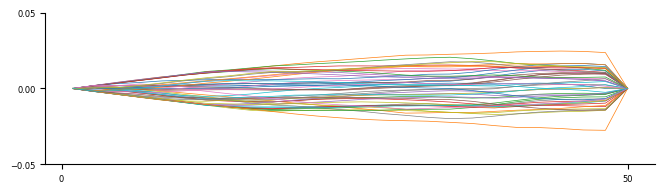

In [98]:
# saveflag = True
saveflag = False

# fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
# ax.spines[['top','right']].set_visible(False)
# layer = 2
# c=0
# times=[0, 4]

# ### Plot responses
# # t=0
# # for i in range(c*par.nClass,(c+1)*par.nClass):
# #             pl.plot(RESP[layer][t,i,::10,:].transpose(), linewidth=0.5)
# for c in [0, 1, 9]:
#     for j, t in enumerate(times):
#         for i in range(c*par.nClass,(c+1)*par.nClass):
#             pl.plot(RESP[layer][t,i,:,:].transpose(), linewidth=0.5)
#         if j==0:
#             ax.xaxis.set_ticks((0,nt)); ax.yaxis.set_ticks((0,0.2))
#         elif j==1:
#             ax.xaxis.set_ticks((0,nt)); ax.yaxis.set_ticks((0,10,20))
#         if saveflag:
#             pl.savefig(figDir+'/resp_c'+str(c)+'t'+str(j)+'.svg', format="svg")
#         ax.cla() 

# ### Plot accuracy
# fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
# ax.spines[['top','right']].set_visible(False)
# pl.plot(np.linspace(1,par.nEpochs,par.nEpochs),np.convolve(np.pad(accTr, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0)
# pl.plot(np.linspace(1,par.nEpochs,par.nEpochs),np.convolve(np.pad(accVal, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0)
# # pl.plot(accTr, linewidth=0.5); pl.plot(accVal, linewidth=0.5)
# ax.xaxis.set_ticks((0,par.nEpochs)); ax.yaxis.set_ticks((0,1))
# if saveflag:
#     pl.savefig(figDir+'/accTrVal.svg', format="svg")

### Plot Feedback Weight Evolution
if par.saveFlag_FBWeights:
    fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
    ax.spines[['top','right']].set_visible(False)
    for j in range(0,1000,100):
        pl.plot(np.linspace(1,par.nEpochs,par.nSave+1),weights[::2,j,:].transpose(), linewidth=0.5)
ax.xaxis.set_ticks((0,par.nEpochs)); ax.yaxis.set_ticks((-.05,0,.05))
if saveflag:
    pl.savefig(figDir+'/fbWeights.svg', format="svg")

# ### Correlation between met responses
# layer = 1
# fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
# # imdata = ax.imshow(stats.zscore(np.reshape(RESP[1][0,:,:,:],[RESP[1].shape[1], RESP[1].shape[2]*RESP[1].shape[3]]), 1).transpose(),vmin=-1.0, vmax=1.0)
# c0 = np.matmul(stats.zscore(np.reshape(RESP[layer][0,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1), stats.zscore(np.reshape(RESP[layer][0,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1).transpose()) / (RESP[layer].shape[2])
# imdata = ax.imshow(c0,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
# if saveflag:
#     pl.savefig(directory+'/figs/'+prefix+'met0_corr.svg', format="svg")
# fig = pl.figure(figsize=tuple(np.array((4.,4.))/2.54)); ax = pl.axes()
# c1 = np.matmul(stats.zscore(np.reshape(RESP[layer][19,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1), stats.zscore(np.reshape(RESP[layer][19,:,:,-1],[RESP[layer].shape[1], RESP[layer].shape[2]]), 1).transpose()) / (RESP[layer].shape[2])
# imdata = ax.imshow(c1,vmin=-1.0, vmax=1.0)
# cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
# if saveflag:
#     pl.savefig(directory+'/figs/'+prefix+'met1_corr.svg', format="svg") 


### Plot triplet distances and loss

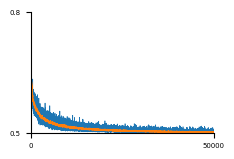

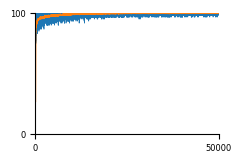

In [133]:
import matplotlib
from matplotlib import pyplot as pl
# saveflag = True
saveflag = False
tripletflag = True
# tripletflag = False

kernel = np.ones(50)/50
prefix = experiment#'classic_original_'
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['axes.labelsize'] = 6
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['savefig.format'] = 'svg'
matplotlib.rcParams['font.family'] = 'sans-serif'

###Plot distances
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  # pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,0]); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),dist[:,1], linestyle='dashed')
  pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,0], linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),dist[:,1], linewidth=0.5)
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=20)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,15,30))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,20))
  # ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'distances.svg', format="svg")

###Plot triplett loss
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  # pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_distX_tr.shape)),np.convolve(l_tri,kernel,mode='same')); 
  pl.plot(np.linspace(1,nt_dist,nt_dist),l_tri, linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(np.pad(l_tri, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
  # ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=0.5*1.05*np.max(l_tri))
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=1.0)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,1))
  ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'loss_triplet.svg', format="svg")

###Plot triplet accuracy
if tripletflag:
  fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
  ax.spines[['top','right']].set_visible(False)
  pl.plot(np.linspace(1,nt_dist,nt_dist),a_tri*100, linewidth=0.5)
  pl.plot(np.linspace(1,nt_dist,nt_dist),np.convolve(np.pad(a_tri*100, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
  ax.set_xlim(xmin=0, xmax=np.log10(nt_dist)); ax.set_ylim(ymin=0.0, ymax=100.)
  # ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
  ax.xaxis.set_ticks((0,nt_dist)); ax.yaxis.set_ticks((0,100))
  ax.tick_params(axis='both', which='major', labelsize=6.0)
  if saveflag:
      pl.savefig(directory+'/figs/'+prefix+'acc_triplet.svg', format="svg")

###Plot output loss
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
# pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),l_tri); pl.plot(np.log10(np.linspace(1,nt_dist,nt_dist)),np.convolve(l_tri,kernel,mode='same')); 
pl.plot(np.linspace(1,nt_out,nt_out),l_out, linewidth=0.5)
pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(np.pad(l_out, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_out)); ax.set_ylim(ymin=0.0, ymax=0.8)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0.0,0.8))
ax.tick_params(axis='both', which='major', labelsize=6.0)
ax.set_xticklabels((0, nt_out), fontdict={'family': 'sans-serif', 'size':5})
ax.set_yticklabels((0.5,0.8), fontdict={'family': 'sans-serif', 'size':5})
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'loss_out.svg', format="svg")

###Plot output accuracy
fig = pl.figure(figsize=tuple(np.array((6.,4.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
pl.plot(np.linspace(1,nt_out,nt_out),a_out*100, linewidth=0.5)
pl.plot(np.linspace(1,nt_out,nt_out),np.convolve(np.pad(a_out*100, (50,50), mode='edge'),kernel,mode='same')[50:-50], linewidth=1.0); 
ax.set_xlim(xmin=0, xmax=np.log10(nt_out)); ax.set_ylim(ymin=0.0, ymax=100.)
# ax.xaxis.set_ticks((np.log10((1,10,100,1000,10000)))); ax.yaxis.set_ticks((0,5))
ax.xaxis.set_ticks((0,nt_out)); ax.yaxis.set_ticks((0,100))
ax.tick_params(axis='both', which='major', labelsize=6.0)
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'acc_out.svg', format="svg")

### Plot met responses over training

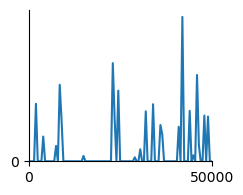

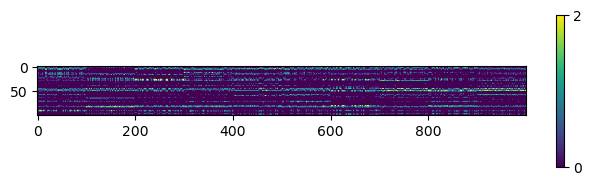

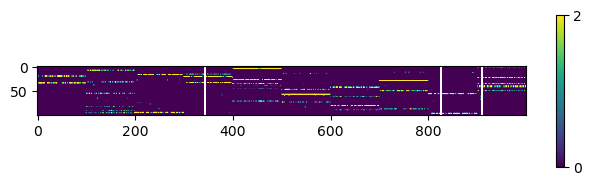

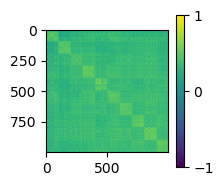

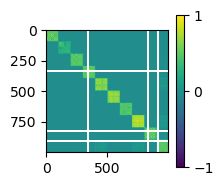

In [134]:
from matplotlib import pyplot as pl
from scipy import stats
pl.rcParams['savefig.dpi'] = 400

saveflag = True
# saveflag = False

### Raw met reponses
fig = pl.figure(figsize=tuple(np.array((6.,5.))/2.54)); ax = pl.axes()
ax.spines[['top','right']].set_visible(False)
plmet = np.squeeze(met[0,:,199])
pl.plot(np.linspace(1,nt_met,nt_met)*save_every,plmet)
ax.set_xlim(xmin=0, xmax=nt_met*save_every); ax.set_ylim(ymin=0.0, ymax=1.05*np.max(plmet))
ax.xaxis.set_ticks((0,nt_met*save_every)); ax.yaxis.set_ticks((0,))
pl.show()

fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[0,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0., 2.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met0.svg', format="svg")
fig = pl.figure(figsize=tuple(np.array((20.,5.))/2.54)); ax = pl.axes()
c0 = stats.zscore(np.squeeze(met[-1,:,:]),0)
imdata = ax.imshow(c0,vmin=0.0, vmax=2.0)
cb = fig.colorbar(imdata, ticks=[0., 2.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met1.svg', format="svg")

### Correlation between met responses
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c0 = np.matmul(stats.zscore(np.squeeze(met[0,:,:]),0).transpose(), stats.zscore(np.squeeze(met[0,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c0,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met0_corr.svg', format="svg")
fig = pl.figure(figsize=tuple(np.array((5.,5.))/2.54)); ax = pl.axes()
c1 = np.matmul(stats.zscore(np.squeeze(met[-1,:,:]),0).transpose(), stats.zscore(np.squeeze(met[-1,:,:]),0)) / met.shape[1]
imdata = ax.imshow(c1,vmin=-1.0, vmax=1.0)
cb = fig.colorbar(imdata, ticks=[-1.0, 0.0, 1.0])
if saveflag:
    pl.savefig(directory+'/figs/'+prefix+'met1_corr.svg', format="svg") 


# Plot weights